# Data Cleaning
---

1. [Cleaning the weather dataset](#Cleaning-the-weather-dataset)
2. [Cleaning the spray dataset](#Cleaning-the-spray-dataset)
3. [Cleaning the train dataset](#Cleaning-the-train-dataset)
4. [Cleaning the test dataset](#Cleaning-the-test-dataset)
5. [Merging the datasets](#Merging-the-datasets)

NOTE: Rebecca's changes
- Standardized formatting across sections
- Standardized column names to be all in lower case
- Standardized names of year, month, day, week, and day of week columns
- Changed latitude and longitude to single column "coordinates" for every dataset
- Added "station" column to train and test set which is the nearest station
- Merged weather and test/train datasets on date and nearest station

### Importing necessary libraries

In [462]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For dates
from datetime import date
from datetime import datetime

# For distance
import geopy


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Overrides Matplotlib theme with Seaborn's 
sns.set(font_scale = 1.2)
sns.set_context('talk')

# Enables Pandas to display all the columns
pd.set_option('display.max_columns', None)

# Enables Pandas to display all the rows
pd.set_option('display.max_rows', None)

# Enables Pandas to display more text in a column
pd.set_option('display.max_colwidth', 100)

pd.options.mode.chained_assignment = None  # default='warn'

### Loading the datasets

In [463]:
weather_csv = 'https://raw.githubusercontent.com/eric-ljk/files/main/weather.csv' 
spray_csv = 'https://raw.githubusercontent.com/eric-ljk/files/main/spray.csv'
train_csv = 'https://raw.githubusercontent.com/eric-ljk/files/main/train.csv' 
test_csv = 'https://raw.githubusercontent.com/eric-ljk/files/main/test.csv'

weather = pd.read_csv(weather_csv)
spray = pd.read_csv(spray_csv)
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

### Loading the 'weather' dataset

In [464]:
# weather = pd.read_csv('../assets/weather.csv')

## Cleaning the weather dataset
---
The data is as follows:

In [465]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


This is the size of the DataFrame in rows and columns:

In [466]:
weather.shape

(2944, 22)

### Checking for null, duplicated and missing values

There are no null values in the DataFrame:

In [467]:
weather.isnull().sum().sum()

0

There are no duplicated values in the DataFrame:

In [468]:
weather.duplicated().sum().sum()

0

There are a number of missing values denoted by 'M':

In [469]:
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0]

Tavg             11
Depart         1472
WetBulb           4
Heat             11
Cool             11
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
AvgSpeed          3
dtype: int64

There are a number of trace values denoted by '  T':

In [470]:
weather.isin(['  T']).sum()[weather.isin(['  T']).sum() > 0]

SnowFall        12
PrecipTotal    318
dtype: int64

There are a number of missing values denoted by '-':

In [471]:
weather.isin(['-']).sum()[weather.isin(['-']).sum() > 0]

Sunrise    1472
Sunset     1472
dtype: int64

There are a number of missing values denoted by ' ':

In [472]:
weather.isin([' ']).sum()[weather.isin([' ']).sum() > 0]

CodeSum    1609
dtype: int64

The missing values will be replaced by 'NaN', and the trace values will be replaced by '0' since they are considered undetectable.

In [473]:
weather.replace(['M','-',' '], np.nan, inplace=True)
weather.replace('  T', 0, inplace=True)

The percentages of null values in columns are as follows:

In [474]:
def nan_pcts(df):
    
    # Gets the sum of null values in each column 
    # The sum is converted to a percentage of total column values
    pct_nan = df.isnull().sum() / df.shape[0] * 100

    # Rounds off the percentage to 2 digits
    pct_nan = round(pct_nan, ndigits=2)

    # Sort the values in descending order
    pct_nan = pct_nan.sort_values(ascending=False)
    
    return pct_nan

In [475]:
nan_pcts(weather)

Water1         100.00
CodeSum         54.65
Sunset          50.00
Depth           50.00
Depart          50.00
SnowFall        50.00
Sunrise         50.00
Tavg             0.37
Heat             0.37
Cool             0.37
SeaLevel         0.31
StnPressure      0.14
WetBulb          0.14
AvgSpeed         0.10
PrecipTotal      0.07
Date             0.00
DewPoint         0.00
Tmin             0.00
Tmax             0.00
ResultSpeed      0.00
ResultDir        0.00
Station          0.00
dtype: float64

In graphical format, the percentages of NaN values for top 15 columns with NaN values are as follows:

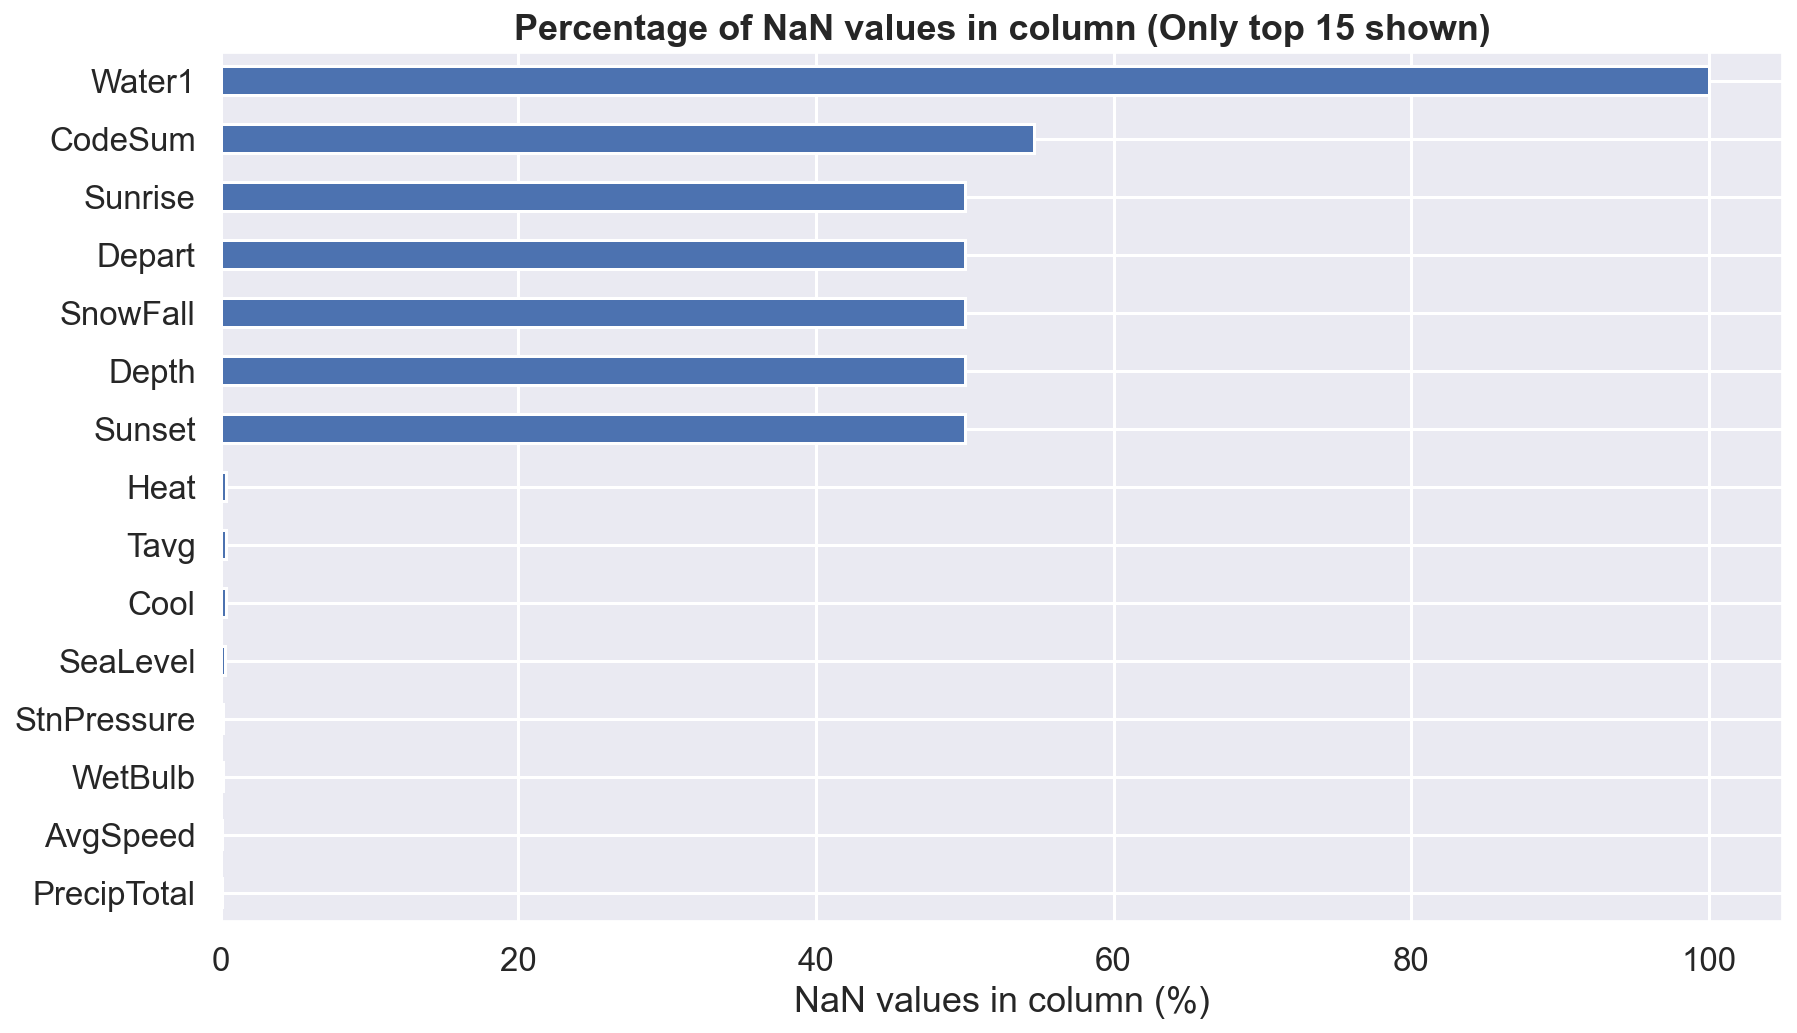

In [476]:
# Gets the percentage of NaN values in each column
isnull_pct = weather.isnull().sum() / weather.shape[0] * 100

# Plots a horizontal bar chart of the values
ax = isnull_pct.sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(14,8))
ax.set_xlabel('NaN values in column (%)')
ax.set_title("Percentage of NaN values in column (Only top 15 shown)", fontweight="bold");

`Water1` has 100% null values. `Sunset`, `Depth`, `Depart`, `SnowFall` and `Sunrise` have 50% null values.

This is a heatmap to check the distribution of the missing values:

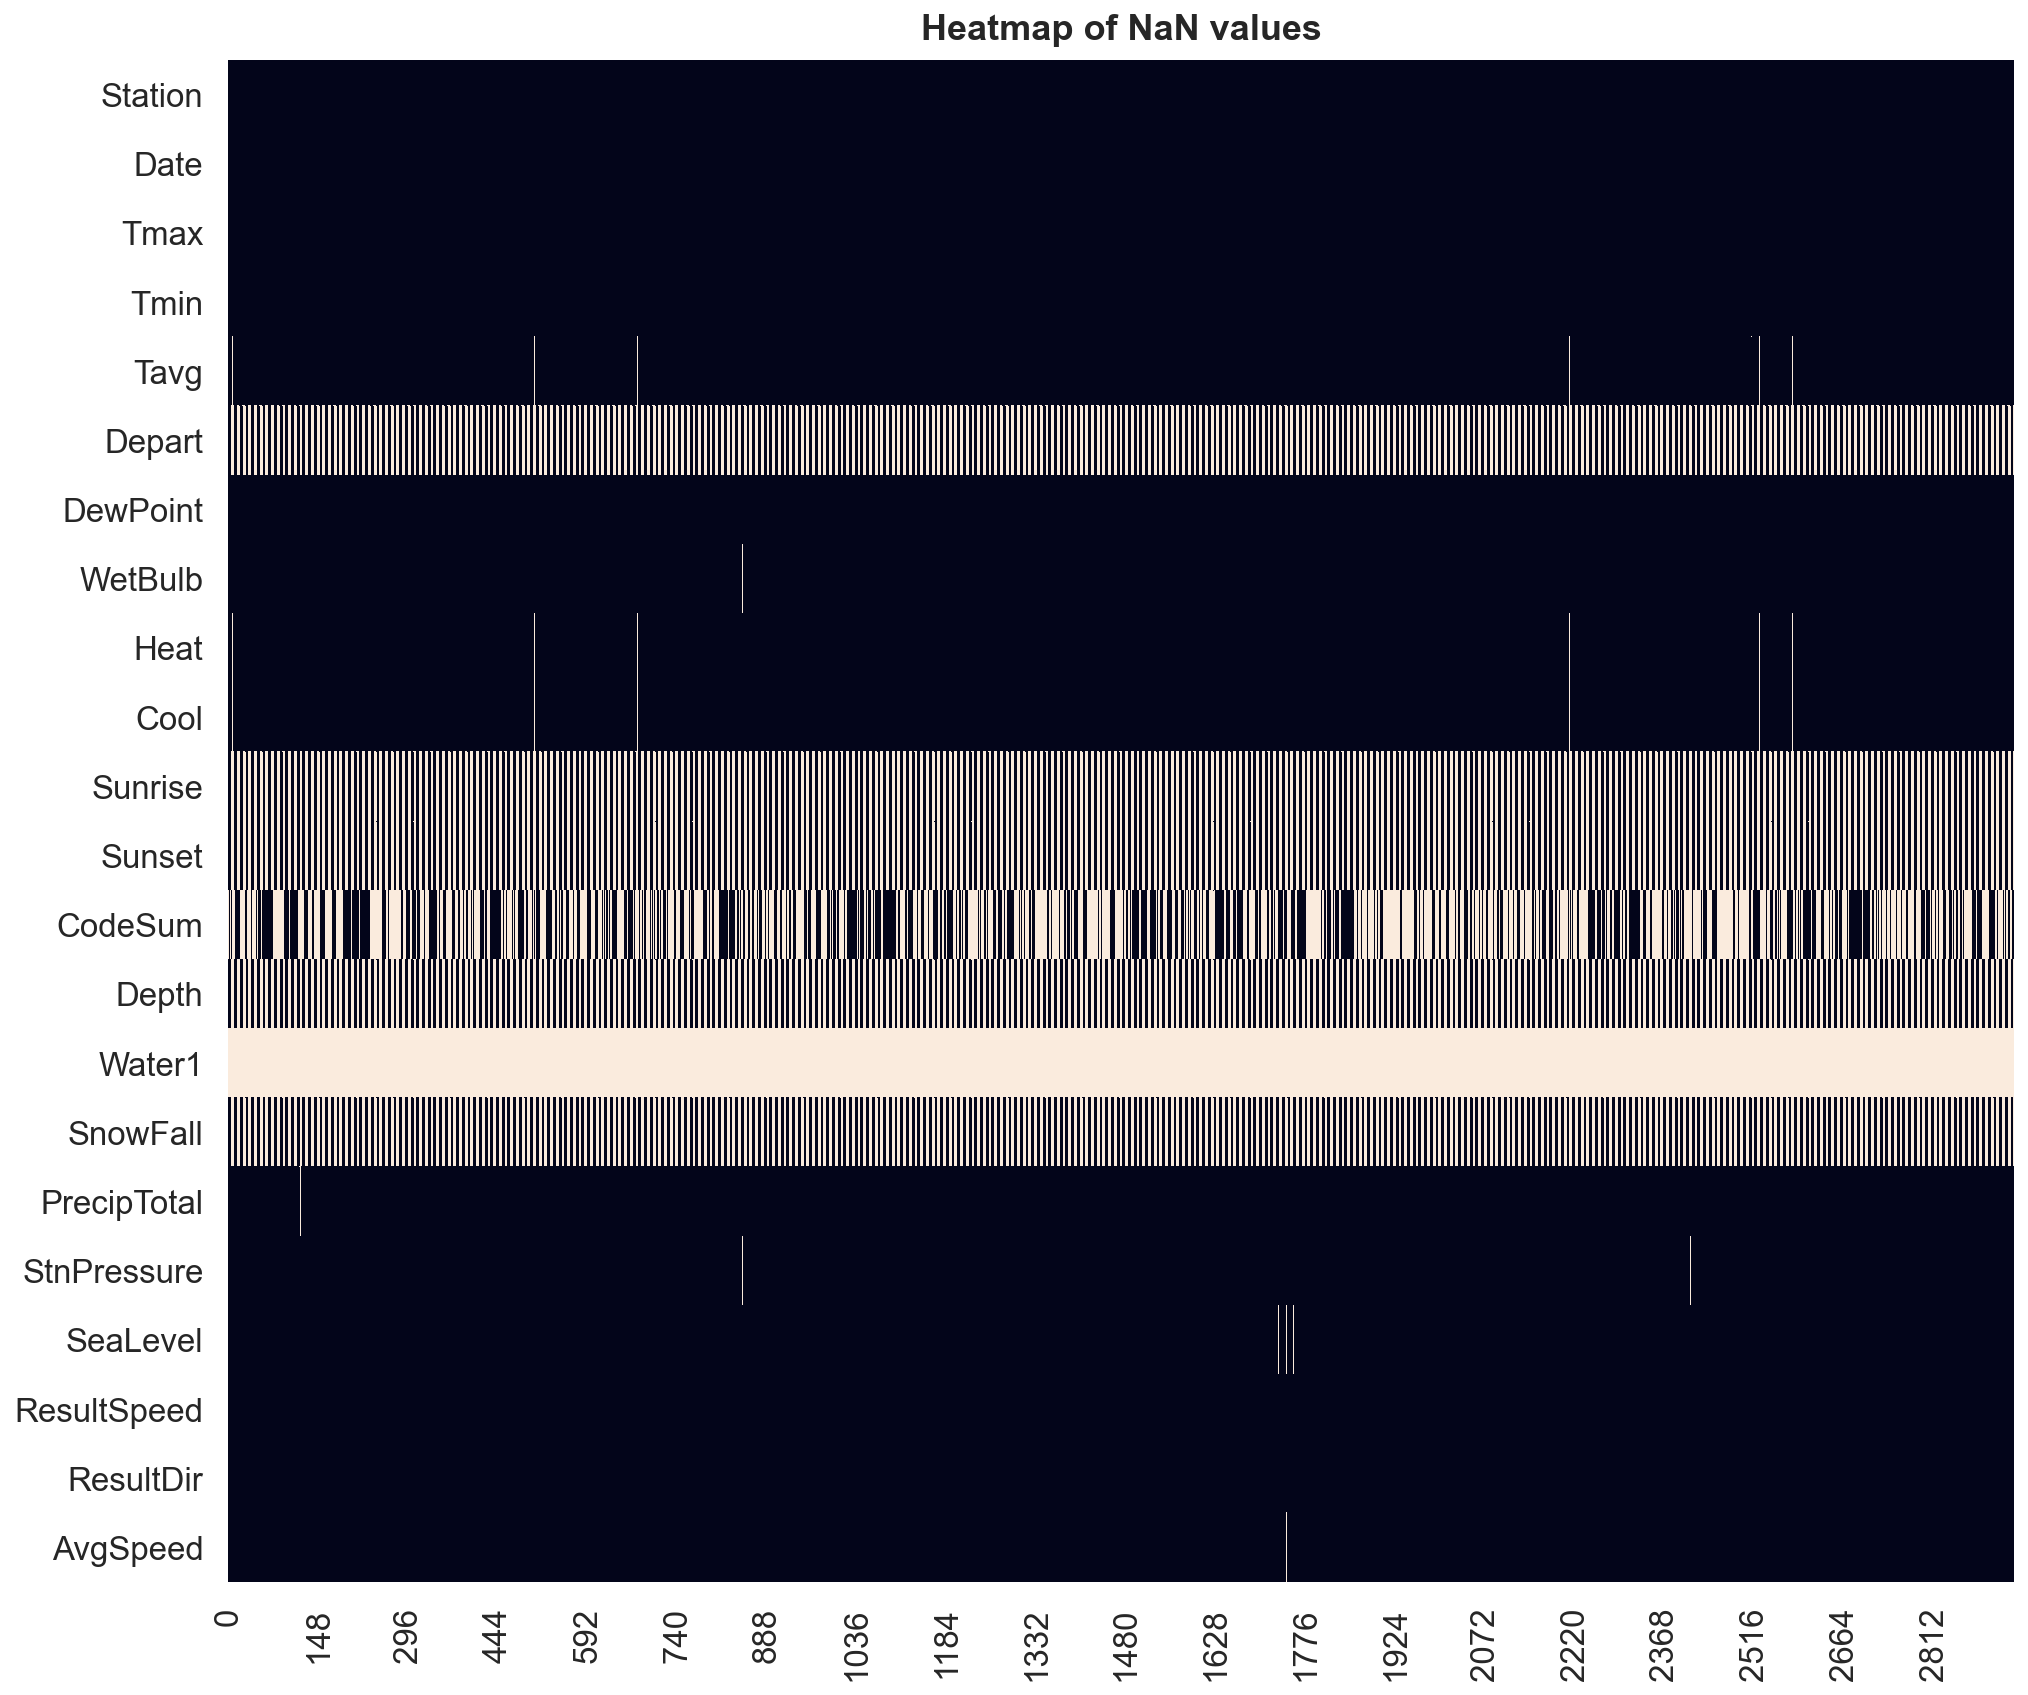

In [477]:
g = sns.heatmap(weather.T.isnull(), yticklabels=True, cbar=None)
g.figure.set_size_inches(16, 14)
g.set_title('Heatmap of NaN values',
            weight='bold',
            pad=10);

It seems that the null values for `Sunset`, `Depth`, `Depart`, `SnowFall` and `Sunrise` are evenly spread. 

In [478]:
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,NaN,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,NaN,NaN,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,NaN,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,NaN,40,50,7,0,NaN,NaN,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,NaN,0.0,0,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,NaN,NaN,42,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,NaN,0,NaN,0.0,0,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,NaN,39,50,5,0,NaN,NaN,NaN,NaN,NaN,NaN,0,29.46,30.09,11.2,7,11.5


According to the DataFrame, every other row has missing values. These seem to correspond to Station 2. 

In [479]:
# Check null values only for Station 1
nan_pcts(weather[weather['Station'] == 1])[['Sunset', 'Depth', 'Depart', 'SnowFall', 'Sunrise']]

Sunset      0.0
Depth       0.0
Depart      0.0
SnowFall    0.0
Sunrise     0.0
dtype: float64

We can see that there are no null values for `Sunset`, `Depth`, `Depart`, `SnowFall` and `Sunrise` for Station 1. We will keep this information in mind for later.

### Dropping the `Water1` column

As this column contains 100% null values, it will be dropped.

In [480]:
'Water1' in weather.columns

True

In [481]:
weather.drop(columns='Water1', inplace=True)

The column has been dropped:

In [482]:
'Water1' in weather.columns

False

### Imputing values for the `CodeSum` column

According to the data documentation, the blanks in the column referred to a weather phenomenon of 'MODERATE'. 

Therefore, the blanks (now null values) will be replaced with 'MD' for 'MODERATE'.

In [483]:
weather['CodeSum'].isnull().sum()

1609

In [484]:
weather['CodeSum'] = weather['CodeSum'].fillna('MD')

The values have been replaced:

In [485]:
weather['CodeSum'].isnull().sum()

0

The values will be converted to a list to make them easier to work with.

In [486]:
weather['CodeSum'] = weather['CodeSum'].str.split(" ")

These are the converted values.

In [487]:
weather['CodeSum'].head()

0        [MD]
1        [MD]
2        [BR]
3    [BR, HZ]
4        [MD]
Name: CodeSum, dtype: object

### Dropping the `Depth` and `SnowFall` columns

The `Depth` and `SnowFall` columns consist nearly of all zeros other than the null values.

In [488]:
weather['Depth'].value_counts()

0    1472
Name: Depth, dtype: int64

In [489]:
weather['SnowFall'].value_counts()

0.0    1459
0        12
0.1       1
Name: SnowFall, dtype: int64

Hence, the columns will be dropped. 

In [490]:
'Depth' in weather.columns

True

In [491]:
'SnowFall' in weather.columns

True

In [492]:
weather.drop(columns=['Depth', 'SnowFall'], inplace=True)

The columns have been dropped:

In [493]:
'Depth' in weather.columns

False

In [494]:
'SnowFall' in weather.columns

False

### Imputing values for the `Sunrise` and `Sunset` columns

As mentioned earlier, the values for these 2 columns are present in Station 1 but not Station 2. 

In [495]:
weather[['Station','Date', 'Sunrise', 'Sunset']].head(5)

,Station,Date,Sunrise,Sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,NaN,NaN
2,1,2007-05-02,0447,1850
3,2,2007-05-02,NaN,NaN
4,1,2007-05-03,0446,1851



We will impute the `Sunrise` and `Sunset` information missing in the Station 2 data from Station 1, as they are located in the same city and are only about 19 miles apart. There will not be much difference in terms of the sunrise or sunset timing. 

In [496]:
# The forward-fill method will be used.

for col in ['Sunrise', 'Sunset']:
    weather[col].fillna(method='ffill', inplace=True)

The values have been filled:

In [497]:
weather[['Station','Date', 'Sunrise', 'Sunset']].head()

,Station,Date,Sunrise,Sunset
0,1,2007-05-01,0448,1849
1,2,2007-05-01,0448,1849
2,1,2007-05-02,0447,1850
3,2,2007-05-02,0447,1850
4,1,2007-05-03,0446,1851


### Imputing values for the `Tavg` column

This column represents the average temperature recorded at the weather station for that day. We can derive the missing values for `Tavg` with the `Tmin` and `Tmax` using the following formula: 

> (`Tmax` + `Tmin`) / 2 

The `Tavg`, `Tmax`, and `Tmin` columns look like this, for rows with missing values: 

In [498]:
weather[weather['Tavg'].isnull()].head()[['Tavg', 'Tmax', 'Tmin']]

,Tavg,Tmax,Tmin
7,NaN,78,51
505,NaN,86,46
675,NaN,62,46
1637,NaN,100,71
2067,NaN,84,72


The missing `Tavg` values will be derived as follows:

In [499]:
# Rounding to the nearest integer is done as values ending with .5 are being produced 
# The appropriate value should be the rounded one. 
# This is known from applying the formula to existing Station 1 values to see if it is accurate. 
weather['Tavg'].fillna(round(((weather['Tmax'] + weather['Tmin'])/2)),inplace=True)

There are no more null values in 'Tavg':

In [500]:
weather['Tavg'].isnull().sum()

0

The datatype of `Tavg` is still not, numerical, however. `Tmax` and `Tmin` are numeric:

In [501]:
weather[['Tavg', 'Tmax', 'Tmin']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tavg    2944 non-null   object
 1   Tmax    2944 non-null   int64 
 2   Tmin    2944 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 69.1+ KB


The datatype will be converted as follows:

In [502]:
# Convert to integer data type to align with Tmax and Tmin
weather['Tavg'] = weather['Tavg'].astype('int64')

The dataype is now converted:

In [503]:
weather[['Tavg']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Tavg    2944 non-null   int64
dtypes: int64(1)
memory usage: 23.1 KB


This is a sample of how the rows previously having null values in `Tavg` look like now.

In [504]:
weather[['Tavg', 'Tmax', 'Tmin']].loc[[7, 505, 675, 1637, 2067]]

,Tavg,Tmax,Tmin
7,64,78,51
505,66,86,46
675,54,62,46
1637,86,100,71
2067,78,84,72


### Imputing values for the `Heat` and `Cool` columns

According to the weather data documentation, a base temperature of 65°F is defined as the benchmark to determine if days are hot or cold days. If the `Tavg` is above that temperature, the difference is recorded under `Heat`. If the `Tavg` is below that temperature, the difference is recorded under `Cool`.

This is what the columns look like:

In [505]:
weather[['Date', 'Tavg', 'Heat', 'Cool']].head()

,Date,Tavg,Heat,Cool
0,2007-05-01,67,0,2
1,2007-05-01,68,0,3
2,2007-05-02,51,14,0
3,2007-05-02,52,13,0
4,2007-05-03,56,9,0


This is what the columns look like, for rows with missing values:

In [506]:
weather[weather['Heat'].isnull()].head()[['Date', 'Tavg', 'Heat', 'Cool']]

,Date,Tavg,Heat,Cool
7,2007-05-04,64,NaN,NaN
505,2008-07-08,66,NaN,NaN
675,2008-10-01,54,NaN,NaN
1637,2011-07-22,86,NaN,NaN
2067,2012-08-22,78,NaN,NaN


To derive the missing values, we can take the Average daily temperature (`Tavg`) and calculate its deviation from the base temperature of 65°F.

This will involve creating a new column with values fully derived from `Tavg` and the 65°F constant. Since we have no missing `Tavg` values, there will be no null values. This is done as follows:

In [507]:
# The new column will be derived from subtracting the 'Tavg' from 65. 
weather['HeatCool'] = 65 - weather['Tavg']

The new column is as such:

In [508]:
weather[['Date', 'Tavg', 'Heat', 'Cool', 'HeatCool']].head()

,Date,Tavg,Heat,Cool,HeatCool
0,2007-05-01,67,0,2,-2
1,2007-05-01,68,0,3,-3
2,2007-05-02,51,14,0,14
3,2007-05-02,52,13,0,13
4,2007-05-03,56,9,0,9


The new column does not have null values:

In [509]:
weather['HeatCool'].isnull().sum()

0

Since the values in this new column effectively represent the values for `Heat` and `Cool` collectively, we will drop the `Heat` and `Cool` columns:

In [510]:
weather.drop(columns=['Heat', 'Cool'], inplace=True)

The columns have been dropped:

In [511]:
'Heat' in weather.columns

False

In [512]:
'Cool' in weather.columns

False

In [513]:
# The values in this new column will be used to replace missing values in the Heat and Cool columns.

# # If 'HeatCool' is more than 1, it'll be classified as Heating season, hence imputed in Heat
# weather.loc[(weather['Heat'].isnull()) & (weather['HeatCool'] >= 0), 'Heat'] = weather['HeatCool']

# # If 'HeatCool' is less than 1, it'll be classified as Cooling season, hence imputed in Cool
# # Value has to be absolute for 'Cool' (no negative figures), hence abs() is used
# weather.loc[(weather['Cool'].isnull()) & (weather['HeatCool'] <= 0), 'Cool'] = abs(weather['HeatCool'])

# # We will then fill all other empty cells in Heat & Cool as 0
# weather.loc[(weather.Heat.isnull()), 'Heat'] = 0
# weather.loc[(weather.Cool.isnull()), 'Cool'] = 0

In [514]:
# # Of no use, drop 'HeatCool' column
# weather.drop(columns = 'HeatCool', inplace=True)

### Imputing values for the `Depart` column 

This column is the last column where the values are present in Station 1 but not Station 2.



In [515]:
weather[['Station','Date', 'Depart', 'Tavg']].head()

,Station,Date,Depart,Tavg
0,1,2007-05-01,14,67
1,2,2007-05-01,NaN,68
2,1,2007-05-02,-3,51
3,2,2007-05-02,NaN,52
4,1,2007-05-03,2,56


The column represents the departure of the average temperature (`Tavg`) from the 'normal'. We can derive the normal value from subtracting the `Depart` from the `Tavg` value. 

There is a use for deriving the normal value. If we have the normal values for Station 1, we can then try to derive the normal values for Station 2. With that, the missing Station 2 `Depart` values can be derived by subtracting the `Normal` from `Tavg`: 

First, we will check the datatype of the `Depart` column.

In [516]:
weather[['Depart']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Depart  1472 non-null   object
dtypes: object(1)
memory usage: 23.1+ KB


The column is not in a numeric datatype. It has to be converted as follows:

In [517]:
# errors='coerce' to complete the conversion despite NaNs in the 'Depart' column
weather['Depart'] = pd.to_numeric(weather['Depart'], errors='coerce')

The value has been converted:

In [518]:
weather[['Depart']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Depart  1472 non-null   float64
dtypes: float64(1)
memory usage: 23.1 KB


We will now create a new column for the 1981-2010 normal temperature. This number will be derived from the `Tavg` and the `Depart` values.  

In [519]:
weather['Normal'] = weather['Tavg'] - weather['Depart']

The column was created (values for Station 2 remain as NaN):

In [520]:
weather[['Station','Date', 'Depart', 'Tavg', 'Normal']].head(10)

,Station,Date,Depart,Tavg,Normal
0,1,2007-05-01,14.0,67,53.0
1,2,2007-05-01,NaN,68,NaN
2,1,2007-05-02,-3.0,51,54.0
3,2,2007-05-02,NaN,52,NaN
4,1,2007-05-03,2.0,56,54.0
5,2,2007-05-03,NaN,58,NaN
6,1,2007-05-04,4.0,58,54.0
7,2,2007-05-04,NaN,64,NaN
8,1,2007-05-05,5.0,60,55.0
9,2,2007-05-05,NaN,60,NaN


It seems like these values are daily normal values, as they change from day to day. According to historical U.S. Climate Normals values from the NOAA, the Station 2 values (CHICAGO MIDWAY INTL ARPT) tend to be about 2 degrees higher than the Station 1 values (CHICAGO O'HARE INTERNATIONAL AIRPORT). Thus, we will impute the normal values for Station 2 as the Station 1 values, plus 2 degrees.

https://www.ncei.noaa.gov/access/us-climate-normals/#dataset=normals-daily&timeframe=81&location=IL&station=USW00094846&month=4

https://www.ncei.noaa.gov/access/us-climate-normals/#dataset=normals-daily&timeframe=81&location=IL&station=USW00014819&month=4

First, we create a function to impute the missing Station 2 `Depart` values.

In [521]:
def impute_depart(row):
    # Applies the function on Station 2 rows.
    if row['Station'] == 2:
        # Gets the Station 1 normal value for the same date.
        station_1_value = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 1)]['Normal'].values[0]
        # Adds 2 to that value obtained. 
        row['Normal'] = station_1_value + 2
    return row

Then, we apply that function:

In [522]:
weather = weather.apply(impute_depart, axis=1)

The filling was successful:

In [523]:
weather[['Station','Date', 'Depart', 'Tavg', 'Normal']].head()

,Station,Date,Depart,Tavg,Normal
0,1,2007-05-01,14.0,67,53.0
1,2,2007-05-01,NaN,68,55.0
2,1,2007-05-02,-3.0,51,54.0
3,2,2007-05-02,NaN,52,56.0
4,1,2007-05-03,2.0,56,54.0


Now, the values in `Depart` will be derived from subtracting `Normal` from `Tavg`. This will overwrite the existing null values in the Station 2 data under the `Depart` column:

In [524]:
weather['Depart'] = weather['Tavg'] - weather['Normal'] 

There are no more null values in `Depart`:

In [525]:
weather['Depart'].isnull().sum()

0

Finally, we will change the datatypes of `Depart` and `Normal` from from float to integer.

In [526]:
# Convert to integer data type to align with Tmax and Tmin
weather['Depart'] = weather['Depart'].astype('int64')
weather['Normal'] = weather['Normal'].astype('int64')

In [527]:
weather[['Depart', 'Normal']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Depart  2944 non-null   int64
 1   Normal  2944 non-null   int64
dtypes: int64(2)
memory usage: 46.1 KB


This is the result.

In [528]:
weather[['Station','Date', 'Depart', 'Tavg', 'Normal']].head()

,Station,Date,Depart,Tavg,Normal
0,1,2007-05-01,14,67,53
1,2,2007-05-01,13,68,55
2,1,2007-05-02,-3,51,54
3,2,2007-05-02,-4,52,56
4,1,2007-05-03,2,56,54


### Imputing values for the `SeaLevel`column

This is the average sea level atmospheric pressure in inches of mercury. As Station 2 is higher than Station 1 in terms of elevation by 50 ft, the `SeaLevel` pressure difference is about 0.01 per 50 ft. However, as 0.01 is quite negligible, we will use the values from Station 1.

Source: https://www.engineeringtoolbox.com/air-altitude-pressure-d_462.html

To do this, we will create a function.

In [529]:
# define a function to fill missing value with data from the other Station
def fill_cross_station(df, column):
    """function to fill missing value in one weather station
    with data in the other weather station"""
    na_index = df[df[column].isnull()].index
    for i in na_index:
        if df.loc[i,'Station'] == 1: 
            weather.loc[i, column] = weather.loc[i+1,column]
        else: 
            weather.loc[i, column] = weather.loc[i-1,column]

In [530]:
# Apply Function to 'Sealevel' column
fill_cross_station(weather, 'SeaLevel')

In [531]:
# Check if all missing value is filled.
weather['SeaLevel'].isnull().sum()

0

### Imputing values for the `StnPressure`column

This is the average station atmospheric pressure in inches of mercury. As Station 2 is higher than Station 1 in terms of elevation by 50 ft, the atmospheric pressure difference is about 0.05 (inches of hg) per 50 ft. Hence, for the missing values for either of the stations, we will add or subtract 0.05 if we are taking Station 1 or Station 2's data respectively. 

* General relation: The higher the air pressure - the lower the altitude.

Source: https://www.engineeringtoolbox.com/air-altitude-pressure-d_462.html

In [532]:
# Locating rows a null values in StnPressure
weather[weather['StnPressure'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,HeatCool,Normal
87,2,2007-06-13,86,68,77,7,53,62,0416,1927,[MD],0.00,NaN,30.09,7.0,5,NaN,-12,70
848,1,2009-06-26,86,69,78,7,60,NaN,0418,1931,[MD],0.00,NaN,29.85,6.4,4,8.2,-13,71
2410,1,2013-08-10,81,64,73,0,57,NaN,0454,1900,[MD],0.00,NaN,30.08,5.3,5,6.5,-8,73
2411,2,2013-08-10,81,68,75,0,55,63,0454,1900,[MD],0.00,NaN,30.07,6.0,6,7.4,-10,75


In [533]:
# As station 1 & 2 has missing data on 10 Aug 2013 we will look at the data around those dates.
weather.loc[2405:2415]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,HeatCool,Normal
2405,2,2013-08-07,91,70,81,6,67,71,0451,1904,[BR],0.01,29.20,29.82,2.4,30,10.5,-16,75
2406,1,2013-08-08,78,65,72,-1,56,62,0452,1903,[MD],0.00,29.26,29.98,8.6,5,9.3,-7,73
2407,2,2013-08-08,79,69,74,-1,55,62,0452,1903,[MD],0.00,29.33,29.96,10.5,5,10.8,-9,75
2408,1,2013-08-09,82,59,71,-2,60,65,0453,1902,[MD],0,29.28,29.98,4.7,27,5.3,-6,73
2409,2,2013-08-09,84,62,73,-2,58,65,0453,1902,[MD],0.00,29.34,29.97,4.9,27,5.6,-8,75
2410,1,2013-08-10,81,64,73,0,57,NaN,0454,1900,[MD],0.00,NaN,30.08,5.3,5,6.5,-8,73
2411,2,2013-08-10,81,68,75,0,55,63,0454,1900,[MD],0.00,NaN,30.07,6.0,6,7.4,-10,75
2412,1,2013-08-11,81,60,71,-2,61,NaN,0455,1859,[RA],0.01,29.35,30.07,2.0,27,3.0,-6,73
2413,2,2013-08-11,84,63,74,-1,57,64,0455,1859,[MD],0,29.42,30.06,4.0,24,5.4,-9,75
2414,1,2013-08-12,82,67,75,2,65,68,0456,1858,"[RA, DZ]",0.27,29.21,29.93,3.5,27,7.5,-10,73



Based on the numbers above - the higher the `SeaLevel` Pressure the higher the atmospheric pressure `StnPressure`. Considering that the 2013-08-10 day's sea level and the next day's (2013-08-11) sea levels are similar, we will impute the missing atmospheric values from the **next day's values** for the respective stations. 

In [534]:
# Replace with the other Station's data that is on the same day.
weather.loc[87,'StnPressure'] = (pd.to_numeric(weather.loc[87-1,'StnPressure']) + 0.05)
weather.loc[848,'StnPressure'] = (pd.to_numeric(weather.loc[848+1,'StnPressure']) - 0.05)

# Replace with next days' data due to similar `SeaLevel`
weather.loc[2410,'StnPressure'] = (pd.to_numeric(weather.loc[2410 + 2,'StnPressure']))
weather.loc[2411,'StnPressure'] = (pd.to_numeric(weather.loc[2411 + 2,'StnPressure']))

### Imputing values for the `WetBulb` column

Based on our research, `WetBulb` and `DewPoint` are measurements of humidity.

`Wet Bulb` temperature is the adiabatic saturation temperature, and can be measured by using a thermometer with the bulb wrapped in wet muslin. The temperature difference between the dry bulb and wet bulb, depends on the humidity of the air. The Wet Bulb temperature is always between the Dry Bulb temperature and the Dew Point.

Dry Bulb Temperature refers basically to the ambient air temperature, for which `Tavg` in our dataset can be an approximate.

Dew Point is the temperature where water vapor starts to condense out of the air (the temperature at which air becomes completely saturated). If the dew-point temperature is close to the dry air temperature - the relative humidity is high if the dew point is well below the dry air temperature - the relative humidity is low.

Let's fill the WetBulb as mid point between `Tavg` and `DewPoint`, i.e.

**`WetBulb` = (`Tavg` + `DewPoint`) / 2**

In [535]:
# check missing values for WetBulb
weather[weather['WetBulb'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,HeatCool,Normal
848,1,2009-06-26,86,69,78,7,60,NaN,0418,1931,[MD],0.00,29.15,29.85,6.4,4,8.2,-13,71
2410,1,2013-08-10,81,64,73,0,57,NaN,0454,1900,[MD],0.00,29.35,30.08,5.3,5,6.5,-8,73
2412,1,2013-08-11,81,60,71,-2,61,NaN,0455,1859,[RA],0.01,29.35,30.07,2.0,27,3.0,-6,73
2415,2,2013-08-12,85,69,77,2,63,NaN,0456,1858,[RA],0.66,29.27,29.92,4.5,26,7.7,-12,75


In [536]:
# fill missing values of WetBulb
wetbulb_na_index = weather[weather['WetBulb'].isnull()].index

for i in wetbulb_na_index:
    weather.loc[i,'WetBulb'] = (weather.loc[i,'Tavg'] + weather.loc[i,'DewPoint']) /2

In [537]:
# Check if null values in wetbulb is removed.
weather[weather['WetBulb'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,HeatCool,Normal


### Imputing values for `PrecipTotal` and `AvgSpeed` columns

We will impute `PrecipTotal` and `AvgSpeed` with the other Station's data, with the `fill_cross_station` function.

In [538]:
fill_cross_station(weather, 'PrecipTotal')
fill_cross_station(weather, 'AvgSpeed')

In [539]:
nan_pcts(weather)

Station        0.0
CodeSum        0.0
HeatCool       0.0
AvgSpeed       0.0
ResultDir      0.0
ResultSpeed    0.0
SeaLevel       0.0
StnPressure    0.0
PrecipTotal    0.0
Sunset         0.0
Date           0.0
Sunrise        0.0
WetBulb        0.0
DewPoint       0.0
Depart         0.0
Tavg           0.0
Tmin           0.0
Tmax           0.0
Normal         0.0
dtype: float64

### Creating year, month, week and day of week columns

In [540]:
# Add Year, Month, Week and Day of Week features
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].apply(lambda x: x.year)
weather['Month'] = weather['Date'].apply(lambda x: x.month)
weather['Day'] = weather['Date'].apply(lambda x: x.day)
weather['Week'] = weather['Date'].apply(lambda x: x.week)
weather['DayOfWeek'] = weather['Date'].apply(lambda x: x.dayofweek)

In [541]:
# .str.replace('(?<!^)([A-Z])', r'_\1')

### Standardizing column names to lower case

In [542]:
weather.columns = weather.columns.str.lower()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   int64         
 5   depart       2944 non-null   int64         
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   sunrise      2944 non-null   object        
 9   sunset       2944 non-null   object        
 10  codesum      2944 non-null   object        
 11  preciptotal  2944 non-null   object        
 12  stnpressure  2944 non-null   object        
 13  sealevel     2944 non-null   object        
 14  resultspeed  2944 non-null   float64       
 15  resultdir    2944 non-null   int64         
 16  avgspe

## Cleaning the spray dataset
---

In [543]:
# Preview of dataset
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [544]:
# Basic info
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


### Standardizing column names to lower case

In [545]:
# Convert columns namesto lower case
spray.columns = spray.columns.str.lower()
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14835 non-null  object 
 1   time       14251 non-null  object 
 2   latitude   14835 non-null  float64
 3   longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


### Checking for duplicate entries

In [546]:
# Check number of duplicate rows
spray.duplicated().value_counts()

False    14294
True       541
dtype: int64

In [547]:
# Look at duplicate rows
spray[spray.duplicated()]

,date,time,latitude,longitude
485,2011-09-07,7:43:40 PM,41.983917,-87.793088
490,2011-09-07,7:44:32 PM,41.986460,-87.794225
491,2011-09-07,7:44:32 PM,41.986460,-87.794225
492,2011-09-07,7:44:32 PM,41.986460,-87.794225
493,2011-09-07,7:44:32 PM,41.986460,-87.794225
494,2011-09-07,7:44:32 PM,41.986460,-87.794225
495,2011-09-07,7:44:32 PM,41.986460,-87.794225
496,2011-09-07,7:44:32 PM,41.986460,-87.794225
497,2011-09-07,7:44:32 PM,41.986460,-87.794225
498,2011-09-07,7:44:32 PM,41.986460,-87.794225


In [548]:
spray.loc[(spray['time'] == '7:44:32 PM') & (spray['date'] == '2011-09-07') 
          & (spray['latitude'] == 41.98646) & (spray['longitude'] == -87.794225)]

,date,time,latitude,longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
494,2011-09-07,7:44:32 PM,41.98646,-87.794225
495,2011-09-07,7:44:32 PM,41.98646,-87.794225
496,2011-09-07,7:44:32 PM,41.98646,-87.794225
497,2011-09-07,7:44:32 PM,41.98646,-87.794225
498,2011-09-07,7:44:32 PM,41.98646,-87.794225


Observations:
- The duplicated entries have the same time, date, and location, possibly due to a result of a data collection error. These duplicated rows will be removed.

In [549]:
# Drop duplicated records
spray_nodup = spray.drop_duplicates()

In [550]:
# Started off with 14835 entries, dropped 541 duplicated entries to get 14294 final non-duplicated entries
spray_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14294 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14294 non-null  object 
 1   time       13710 non-null  object 
 2   latitude   14294 non-null  float64
 3   longitude  14294 non-null  float64
dtypes: float64(2), object(2)
memory usage: 558.4+ KB


### Checking for null values

In [551]:
# Check total number of null values
spray_nodup.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

In [552]:
# Look at the rows with null values
spray_nodup[spray_nodup['time'].isnull()]

,date,time,latitude,longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
1035,2011-09-07,NaN,41.986372,-87.794862
1036,2011-09-07,NaN,41.986228,-87.795582
1037,2011-09-07,NaN,41.984836,-87.793998
1038,2011-09-07,NaN,41.984836,-87.794670
1039,2011-09-07,NaN,41.984884,-87.795198


In [553]:
# Check if the rows with null values have a common date
spray_nodup[spray_nodup['time'].isnull()].groupby('date').count()

,time,latitude,longitude
date,,,
2011-09-07,0,584,584


Observations:
- All the null values seem to have the same date '2011-09-07'.
- Since the null values make up around 4% of our data, it is safe to drop the rows will null values.

In [554]:
# Drop rows will null values
spray_nonull = spray_nodup.dropna()

In [555]:
# Check if rows with null values have been dropped
spray_nonull.isnull().sum()

date         0
time         0
latitude     0
longitude    0
dtype: int64

<Figure size 1080x864 with 0 Axes>

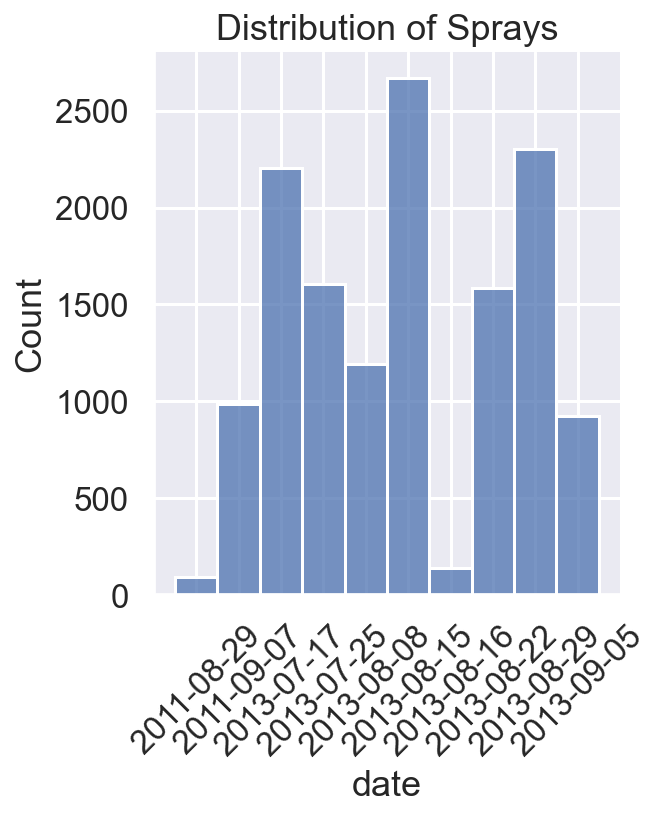

In [556]:
plt.figure(figsize=(15,12))
sns.displot(spray_nonull['date'])
plt.xticks(rotation=45)
plt.title('Distribution of Sprays');

In [557]:
spray_nonull.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


### Creating year, month, week and day of week columns

In [558]:
# Add Year, Month, Week and Day of Week features
spray_nonull['date'] = pd.to_datetime(spray_nonull['date'])
spray_nonull['year'] = spray_nonull['date'].apply(lambda x: x.year)
spray_nonull['month'] = spray_nonull['date'].apply(lambda x: x.month)
spray_nonull['day'] = spray_nonull['date'].apply(lambda x: x.day)
spray_nonull['week'] = spray_nonull['date'].apply(lambda x: x.week)
spray_nonull['dayofweek'] = spray_nonull['date'].apply(lambda x: x.dayofweek)

In [559]:
spray_nonull.head()

,date,time,latitude,longitude,year,month,day,week,dayofweek
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,35,0
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,35,0
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,35,0
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,35,0
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,35,0


### Creating coordinates column

In [560]:
spray["coordinates"] = (list(zip((round(spray["latitude"], 6)), round(spray["longitude"], 6))))

In [561]:
spray.drop("latitude", axis = 1, inplace = True)
spray.drop("longitude", axis = 1, inplace = True)

In [562]:
spray.head()

,date,time,coordinates
0,2011-08-29,6:56:58 PM,"(42.391623, -88.089163)"
1,2011-08-29,6:57:08 PM,"(42.391348, -88.089163)"
2,2011-08-29,6:57:18 PM,"(42.391022, -88.089157)"
3,2011-08-29,6:57:28 PM,"(42.390637, -88.089158)"
4,2011-08-29,6:57:38 PM,"(42.39041, -88.088858)"


## Cleaning the train dataset
---
Lets have a brief look at our training dataset first.

In [563]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [564]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [565]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


We can see 12 columns with our Target Variable being the WnvPresent column. Let's continue data cleaning.

### Checking for null or missing values

In [566]:
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

Appears we have no null values to deal with so our data should be clean.

### Standardizing column names to lower case

Let's standardize our column formatting to lower case letters with underscores separating spaces.

In [567]:
train.columns = train.columns.str.lower()
train.info()
# There are no spaces in the column names thus no need for an additional replace method call

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10506 non-null  object 
 1   address                 10506 non-null  object 
 2   species                 10506 non-null  object 
 3   block                   10506 non-null  int64  
 4   street                  10506 non-null  object 
 5   trap                    10506 non-null  object 
 6   addressnumberandstreet  10506 non-null  object 
 7   latitude                10506 non-null  float64
 8   longitude               10506 non-null  float64
 9   addressaccuracy         10506 non-null  int64  
 10  nummosquitos            10506 non-null  int64  
 11  wnvpresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Creating year, month, week and day of week columns

We do note that the data column is in the format YYYY-MM-DD. We need to split them up for use together with our seasonality data from our weather.csv. I will split this column into years, month and date first.

In [568]:
# Converting our date column into a datetime object before retrieving the year from the isocalendar method
train['year'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[0] for x in train['date']]
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007


In [569]:
train['month'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).month for x in train['date']]
train.tail()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1,2013,9
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0,2013,9
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0,2013,9
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0,2013,9
10505,2013-09-26,"4200 West 65th Street, Chicago, IL 60621, USA",CULEX PIPIENS/RESTUANS,42,W 65TH ST,T235,"4200 W 65TH ST, Chicago, IL",41.776428,-87.627096,8,1,0,2013,9


In [570]:
# Converting our date column into a datetime object before using the day method to retrieve the day of the month
train['day'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).day for x in train['date']]
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29


In [571]:
train['dayofweek'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[2] for x in train['date']]
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day,dayofweek
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,2
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,2
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29,2
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29,2
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29,2


In [572]:
# Converting our date column into a datetime object before retrieving the week of year from the isocalendar method
train['week'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[1] for x in train['date']]
train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day,dayofweek,week
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,2,22
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,2,22
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29,2,22
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29,2,22
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29,2,22


### Creating coordinates column

In [573]:
train["coordinates"] = (list(zip(train["latitude"], train["longitude"])))

In [574]:
train.drop("latitude", axis = 1, inplace = True)
train.drop("longitude", axis = 1, inplace = True)

In [575]:
train.head(2)

,date,address,species,block,street,trap,addressnumberandstreet,addressaccuracy,nummosquitos,wnvpresent,year,month,day,dayofweek,week,coordinates
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,1,0,2007,5,29,2,22,"(41.95469, -87.800991)"
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,1,0,2007,5,29,2,22,"(41.95469, -87.800991)"


Train Dataset is now cleaned.

## Cleaning the test dataset
---

Similar to our Train Dataset, we will perform the same steps to our Test Dataset as well.

In [576]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [577]:
test.describe()

,Id,Block,Latitude,Longitude,AddressAccuracy
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000
mean,58147.000000,41.131100,41.849389,-87.693658,7.954357
std,33571.041765,24.864726,0.106593,0.080699,1.252733
min,1.000000,10.000000,41.644612,-87.930995,3.000000
25%,29074.000000,18.000000,41.753411,-87.750938,8.000000
50%,58147.000000,39.000000,41.862292,-87.694991,8.000000
75%,87220.000000,61.000000,41.951866,-87.648860,9.000000
max,116293.000000,98.000000,42.017430,-87.531635,9.000000


In [578]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


Note our Target Variable WnvPresent is missing from our test dataset.

### Standardizing column names to lower case

In [579]:
test.columns = test.columns.str.lower()
test.info()
# There are no spaces in the column names thus no need for an additional replace method call

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      116293 non-null  int64  
 1   date                    116293 non-null  object 
 2   address                 116293 non-null  object 
 3   species                 116293 non-null  object 
 4   block                   116293 non-null  int64  
 5   street                  116293 non-null  object 
 6   trap                    116293 non-null  object 
 7   addressnumberandstreet  116293 non-null  object 
 8   latitude                116293 non-null  float64
 9   longitude               116293 non-null  float64
 10  addressaccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


### Set index for Test Dataset (No need for google Colab)

In [580]:
# test.set_index(keys = 'id', inplace = True)
# pandas in google colab has already took into account of index and thus no need to set index

In [581]:
test.isnull().sum()

id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
dtype: int64

Appears we have no null values to deal with so our data should be clean.

### Creating year, month, week and day of week columns

We do note that the data column is in the format YYYY-MM-DD. We need to split them up for use together with our seasonality data from our weather.csv. I will split this column into years, month and date first.

In [582]:
# Converting our date column into a datetime object before retrieving the year from the isocalendar method
test['year'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[0] for x in test['date']]
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008


In [583]:
# Converting our date column into a datetime object before using the month method to retrieve the month
test['month'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).month for x in test['date']]
test.tail()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year,month
116288,116289,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX SALINARIUS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,8,2014,10
116289,116290,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX TERRITANS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,8,2014,10
116290,116291,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX TARSALIS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,8,2014,10
116291,116292,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",UNSPECIFIED CULEX,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,8,2014,10
116292,116293,2014-10-02,"2100 North Cannon Drive, Chicago, IL 60614, USA",CULEX ERRATICUS,21,N CANNON DR,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.63359,8,2014,10


In [584]:
# Converting our date column into a datetime object before using the day method to retrieve the day of the month
test['day'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).day for x in test['date']]
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year,month,day
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11


In [585]:
test['dayofweek'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[2] for x in test['date']]
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year,month,day,dayofweek
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3


In [586]:
# Converting our date column into a datetime object before retrieving the week of year from the isocalendar method
test['week'] = [datetime.date(datetime.strptime(x, '%Y-%m-%d')).isocalendar()[1] for x in test['date']]
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,year,month,day,dayofweek,week
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3,24
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3,24
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3,24
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3,24
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2008,6,11,3,24


### Creating coordinates column

In [587]:
test["coordinates"] = list(zip(test["latitude"], test["longitude"]))

In [588]:
test.drop("latitude", axis = 1, inplace = True)
test.drop("longitude", axis = 1, inplace = True)

In [589]:
test.head(2)

,id,date,address,species,block,street,trap,addressnumberandstreet,addressaccuracy,year,month,day,dayofweek,week,coordinates
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,2008,6,11,3,24,"(41.95469, -87.800991)"
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,2008,6,11,3,24,"(41.95469, -87.800991)"


Data Cleaning for Train and Test Datasets is completed.

## Merging the datasets
---
We will first create a new column in test and train dataset to indicate whether station 1 or station 2 is nearer.

In [591]:
station1_coords = (41.995, -87.933)
station2_coords = (41.786, -87.752)

def neareststation(cell):
    dist_to_1 = geopy.distance.distance(cell, station1_coords)
    dist_to_2 = geopy.distance.distance(cell, station2_coords)
    if dist_to_1 < dist_to_2:
        return 1
    else:
        return 2

train["station"] = train["coordinates"].apply(neareststation)
test["station"] = test["coordinates"].apply(neareststation)

We will merge the weather data into the train and test dataset according to the date and the nearest station.

In [602]:
merged_train = pd.merge(train, weather, how = "left", on = ["year", "month", "day", "station"])
merged_test = pd.merge(test, weather, how = "left", on = ["year", "month", "day", "station"])

We will now clean up the columns that were duplicated due to the merging.

In [609]:
merged_train.drop(["date_y", "week_y", "dayofweek_y"], axis = 1, inplace = True)
merged_test.drop(["date_y", "week_y", "dayofweek_y"], axis = 1, inplace = True)

merged_train.rename(columns = {"date_x": "date", "week_x": "week", "dayofweek_x": "dayofweek"}, inplace = True)
merged_test.rename(columns = {"date_x": "date", "week_x": "week", "dayofweek_x": "dayofweek"}, inplace = True)

In [610]:
merged_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,addressaccuracy,nummosquitos,wnvpresent,year,month,day,dayofweek,week,coordinates,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,heatcool,normal
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,1,0,2007,5,29,2,22,"(41.95469, -87.800991)",1,88,60,74,10,58,65,0421,1917,"[BR, HZ]",0.00,29.39,30.11,5.8,18,6.5,-9,64
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634, USA",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",9,1,0,2007,5,29,2,22,"(41.95469, -87.800991)",1,88,60,74,10,58,65,0421,1917,"[BR, HZ]",0.00,29.39,30.11,5.8,18,6.5,-9,64
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",9,1,0,2007,5,29,2,22,"(41.994991, -87.769279)",1,88,60,74,10,58,65,0421,1917,"[BR, HZ]",0.00,29.39,30.11,5.8,18,6.5,-9,64
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,1,0,2007,5,29,2,22,"(41.974089, -87.824812)",1,88,60,74,10,58,65,0421,1917,"[BR, HZ]",0.00,29.39,30.11,5.8,18,6.5,-9,64
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",8,4,0,2007,5,29,2,22,"(41.974089, -87.824812)",1,88,60,74,10,58,65,0421,1917,"[BR, HZ]",0.00,29.39,30.11,5.8,18,6.5,-9,64
